In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

# Load and Pre-Process the Data

In [2]:
df = pd.read_csv('../data/founder_V0.3_founder.csv')

In [3]:
df.columns = df.columns.str.replace(' ', '_')
df.columns 

Index(['Full_Name', 'Primary_Job_Title', 'Bio', 'Gender',
       'Number_of_News_Articles', 'Number_of_Founded_Organizations',
       'Number_of_Portfolio_Companies', 'Number_of_Investments_x',
       'Number_of_Partner_Investments', 'Number_of_Lead_Investments_x',
       'Number_of_Exits_x', 'Number_of_Events_x', 'Categories',
       'Headquarters_Location_', 'Operating_Status', 'Founded_Date',
       'Closed_Date', 'Company_Type', 'Number_of_Founders', 'Success',
       'Founder'],
      dtype='object')

In [4]:
df.shape

(18361, 21)

# Normalization

In [5]:
df['Number_of_News_Articles'] = df['Number_of_News_Articles']/df['Number_of_News_Articles'].max()

In [6]:
df['Number_of_Founded_Organizations'] = df['Number_of_Founded_Organizations']/df['Number_of_Founded_Organizations'].max()

In [7]:
df['Number_of_Portfolio_Companies'] = df['Number_of_Portfolio_Companies']/df['Number_of_Portfolio_Companies'].max()

In [8]:
df['Number_of_Investments_x'] = df['Number_of_Investments_x'] / df['Number_of_Investments_x'].max()

In [9]:
df['Number_of_Partner_Investments'] = df['Number_of_Partner_Investments'] /df['Number_of_Partner_Investments'].max()

In [10]:
df['Number_of_Lead_Investments_x'] = df['Number_of_Lead_Investments_x']/ df['Number_of_Lead_Investments_x'].max()

In [11]:
df['Number_of_Exits_x'] = df['Number_of_Exits_x'] / df['Number_of_Exits_x'].max()

In [12]:
df['Number_of_Events_x'] = df['Number_of_Events_x']/ df['Number_of_Events_x'].max()

# OHE Headquarters & Categories

In [13]:
country_Dummies = pd.get_dummies(df['Headquarters_Location_'])
df = pd.concat([df, country_Dummies], axis = 1)
df.shape

(18361, 163)

In [14]:
def get_unique_vals(column_name):
    unique_arr = []
    for val in df[column_name].values:
        arr = val.split(',')
        for category in arr:
            if category not in unique_arr:
                unique_arr.append(category.strip())
    return unique_arr

In [15]:
def get_all_vals(column_name):
    categories_arr = []
    for val in df[column_name].values:
        arr = val.split(',')
        categories_arr.append(arr[0].strip())
    return categories_arr


In [16]:
category_count_df = pd.Series(get_all_vals('Categories'))
category_count_df = category_count_df.value_counts() # count of category value counts
category_df = get_all_vals('Categories') # df of all category values 
unique_category_df = get_unique_vals('Categories')
cat_and_count_df = dict(zip(unique_category_df, category_count_df))

top_10_cat_df = category_count_df.head(10)
print(top_10_cat_df)
# hard code 10 w/ regex... no need to split column just match for specific keyword

Software               818
Health Care            532
Mobile                 467
E-Commerce             400
Analytics              394
Internet               384
Enterprise Software    352
SaaS                   308
0                      306
Apps                   288
dtype: int64


In [201]:
for row in df['Categories'].iteritems():
    for val in top_10_cat_df.iteritems():
        if str(val[0]) == str(row[1]):
            

In [17]:
final_category_df = pd.DataFrame(category_df, columns=["Category"])
final_category_df = pd.get_dummies(final_category_df)
final_category_df.columns = final_category_df.columns.str.replace(' ', '_')
print(final_category_df.columns)


Index(['Category_0', 'Category_3D_Printing', 'Category_3D_Technology',
       'Category_A/B_Testing', 'Category_Accounting', 'Category_Ad_Network',
       'Category_Ad_Retargeting', 'Category_Ad_Targeting',
       'Category_Advanced_Materials', 'Category_Adventure_Travel',
       ...
       'Category_Wholesale', 'Category_Wind_Energy', 'Category_Windows_Phone',
       'Category_Wine_And_Spirits', 'Category_Wireless', 'Category_Women's',
       'Category_Young_Adults', 'Category_eSports', 'Category_iOS',
       'Category_mHealth'],
      dtype='object', length=584)


In [18]:
df = pd.concat([df, final_category_df], axis = 1)
df.shape # 583 + 163


(18361, 747)

In [19]:
df['Gender'].value_counts() # 131 people responded 2
index_names = df[df["Gender"] == 2].index
df.drop(index_names, inplace=True)

In [20]:
clean_df = pd.DataFrame(df)
clean_df.head(5)

,Full_Name,Primary_Job_Title,Bio,Gender,Number_of_News_Articles,Number_of_Founded_Organizations,Number_of_Portfolio_Companies,Number_of_Investments_x,Number_of_Partner_Investments,Number_of_Lead_Investments_x,...,Category_Wholesale,Category_Wind_Energy,Category_Windows_Phone,Category_Wine_And_Spirits,Category_Wireless,Category_Women's,Category_Young_Adults,Category_eSports,Category_iOS,Category_mHealth
0,Elon Musk,"Chairman, Product Architect & CEO",Elon co-founded Tesla and continues to oversee...,1,0.734069,0.538462,0.112245,0.187500,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,JB Straubel,Co-Founder and CTO,The story of JB Straubel's career started at a...,1,0.005082,0.153846,0.010204,0.008929,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Mark Zuckerberg,Founder & CEO,Mark Zuckerberg is the founder and CEO of Face...,1,1.000000,0.769231,0.061224,0.062500,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Ross Mason,Founder and VP of Product Strategy,"Created the Mule Project, Founded MuleSoft, go...",1,0.006505,0.076923,0.061224,0.062500,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,Rahul Gandhi,Co-Founder & SVP of Finance Operations,Rahul is a Co-founder & Senior Vice President ...,1,0.043754,0.076923,0.000000,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
X = clean_df.drop(['Primary_Job_Title', 'Operating_Status', 'Company_Type', 'Success', 'Full_Name', 'Bio', 'Categories', 'Headquarters_Location_'], axis = 1)
y = clean_df['Success'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1234)
X.shape


(18230, 739)

# XGBoost

In [22]:
xgb_classifier = xgb.XGBClassifier(n_estimators= 1000, objective='binary:logistic', booster='gbtree', learning_rate=.3, colsample_bytree=.3, reg_alpha= .3, random_state = 1234)
xgb_classifier.fit(x_train, y_train)
xgb_y_pred = xgb_classifier.predict(x_test)

xgb_train_score = round(xgb_classifier.score(x_train, y_train)*100, 3)
xgb_test_score = round(xgb_classifier.score(x_test, y_test)*100, 3)

print("Train Accuracy: " + str(xgb_train_score))
print("Test Accuracy: " + str(xgb_test_score))


Train Accuracy: 82.33
Test Accuracy: 79.622


In [ ]:
xgb.plot_importance(xgb_classifier)
plt.rcParams['figure.figsize'] = [150, 100]
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))

print("RMSE: " + str(rmse))
print("MSE: " + str(mean_squared_error(y_test, xgb_y_pred)))

RMSE: 0.451425486464766
MSE: 0.20378496982995062


# KNearestNeighbors

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors= 10, algorithm= 'auto', n_jobs=-1)

knn.fit(x_train, y_train)

knn_y_pred = knn.predict(x_test)

knn_train_score = round(knn.score(x_train, y_train)*100, 2)
knn_test_score = round(knn.score(x_test, y_test)*100, 2)

print(knn_train_score)
print(knn_test_score)


79.91
76.25


In [27]:
from sklearn.model_selection import cross_val_score 
k_neighbor = list(range(1, 24, 2))

cross_val_scores = []

for k in k_neighbor:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv = 10, scoring = 'accuracy')
    cross_val_scores.append(scores.mean())
print(cross_val_scores)

In [ ]:
print(max(cross_val_scores))

In [ ]:
misclassification_error = [1 - score for score in cross_val_scores]

best_k = k_neighbor[misclassification_error.index(min(misclassification_error))]
print(best_k)

In [ ]:
plt.plot(k_neighbor, misclassification_error)
plt.xlabel("Number of Neighbors")
plt.ylabel("Misclassification Effor")
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

# Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_classification = RandomForestClassifier(n_estimators=int(np.sqrt(len(X.columns))), n_jobs=15, random_state= 1234)

rf_classification.fit(x_train, y_train)

rf_y_pred = rf_classification.predict(x_test)

rf_score_TEST = round(rf_classification.score(x_test, y_test)*100, 2)
rf_score_TRAIN = round(rf_classification.score(x_train, y_train)*100, 2)

print("Score on Training Data: " + str(rf_score_TRAIN))
print("Score on Testing Data: " + str(rf_score_TEST))


Score on Training Data: 99.34
Score on Testing Data: 81.71


# Gaussian Naive Bayes

In [29]:
from sklearn.naive_bayes import GaussianNB

gnb_clf = GaussianNB()
gnb_clf.fit(x_train, y_train)

gnb_y_pred = gnb_clf.predict(x_test)

gnb_score_TRAIN = round(gnb_clf.score(x_train, y_train)*100, 2)
gnb_score_TEST = round(gnb_clf.score(x_test, y_test)*100, 2)

print("{} Score on Training Data: ".format(str(gnb_clf.__class__.__name__)) + str(gnb_score_TRAIN))
print("{} Score on Testing Data: ".format(str(gnb_clf.__class__.__name__)) + str(gnb_score_TEST))

GaussianNB Score on Training Data: 53.4
GaussianNB Score on Testing Data: 50.38


# Decision Tree Classifier

In [30]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_features='sqrt', random_state=1234, class_weight='balanced')

dt_clf.fit(x_train, y_train)

dt_y_pred = dt_clf.predict(x_test)

dt_score_TRAIN = round(dt_clf.score(x_train, y_train)*100, 2)
dt_score_TEST = round(dt_clf.score(x_test, y_test)*100, 2)

print("{} TRAINING Score: ".format(str(dt_clf.__class__.__name__)) + str(dt_score_TRAIN))
print("{} TESTING Score: ".format(str(dt_clf.__class__.__name__)) + str(dt_score_TEST))


DecisionTreeClassifier TRAINING Score: 99.41
DecisionTreeClassifier TESTING Score: 75.92


# Log Regression

In [31]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()

log_clf.fit(x_train, y_train)

log_y_pred = log_clf.predict(x_test)

log_score_TRAIN = round(log_clf.score(x_train, y_train)*100, 2)
log_score_TEST = round(log_clf.score(x_test, y_test)*100, 2)

print("{} TRAINING Score: ".format(str(log_clf.__class__.__name__)) + str(log_score_TRAIN))
print("{} TESTING Score: ".format(str(log_clf.__class__.__name__)) + str(log_score_TEST))


LogisticRegression TRAINING Score: 62.2
LogisticRegression TESTING Score: 63.38


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Ensemble Model

In [62]:
from sklearn.ensemble import VotingClassifier

rf_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()
xgb_clf = xgb.XGBClassifier()
# dt_clf = DecisionTreeClassifier()

voting_clf = VotingClassifier(
    estimators= [('rf', rf_clf), ('knn', knn_clf), ('xgb', xgb_clf)],
    voting='soft' # more weight to highly confident votes
)

voting_clf.fit(x_train, y_train)
voting_y_pred = voting_clf.predict(x_test)

voting_train_score = round(voting_clf.score(x_train, y_train)*100, 2)
voting_test_score = round(voting_clf.score(x_test, y_test)*100, 2)

print(voting_train_score)
print(voting_test_score)
print("\n")

for classifier in (rf_clf, knn_clf, xgb_clf, voting_clf):
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    print(classifier.__class__.__name__)
    print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
    print("RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred))))
    print("MSE: " + str(mean_squared_error(y_test, y_pred)))
    print('\n\n')



92.62
81.24
RandomForestClassifier
Accuracy: 0.8261108063631377
RMSE: 0.41700023217842735
MSE: 0.1738891936368623



KNeighborsClassifier
Accuracy: 0.7729018102029621
RMSE: 0.47654820301522266
MSE: 0.22709818979703786



XGBClassifier
Accuracy: 0.775644541963796
RMSE: 0.4736617548802141
MSE: 0.22435545803620405



VotingClassifier
Accuracy: 0.8113000548546352
RMSE: 0.43439606944051046
MSE: 0.18869994514536478





# Confusion Matrix & AUC

In [33]:
from sklearn.metrics import confusion_matrix

i = 0
model_predictions = [xgb_y_pred, knn_y_pred, log_y_pred, rf_y_pred, gnb_y_pred, dt_y_pred]
for pred in model_predictions:
    print("Confusion Matrix: {}".format(model_predictions[i].__class__.__name__) + " " + str(i) + str('\n') + str(confusion_matrix(y_test, pred)))
    i += 1



Confusion Matrix: ndarray 0
[[1961  300]
 [ 443  942]]
Confusion Matrix: ndarray 1
[[1965  296]
 [ 570  815]]
Confusion Matrix: ndarray 2
[[1986  275]
 [1060  325]]
Confusion Matrix: ndarray 3
[[1987  274]
 [ 393  992]]
Confusion Matrix: ndarray 4
[[ 614 1647]
 [ 162 1223]]
Confusion Matrix: ndarray 5
[[1824  437]
 [ 441  944]]


Text(0.5, 1.0, 'Rand Forest Confusion Matrix')

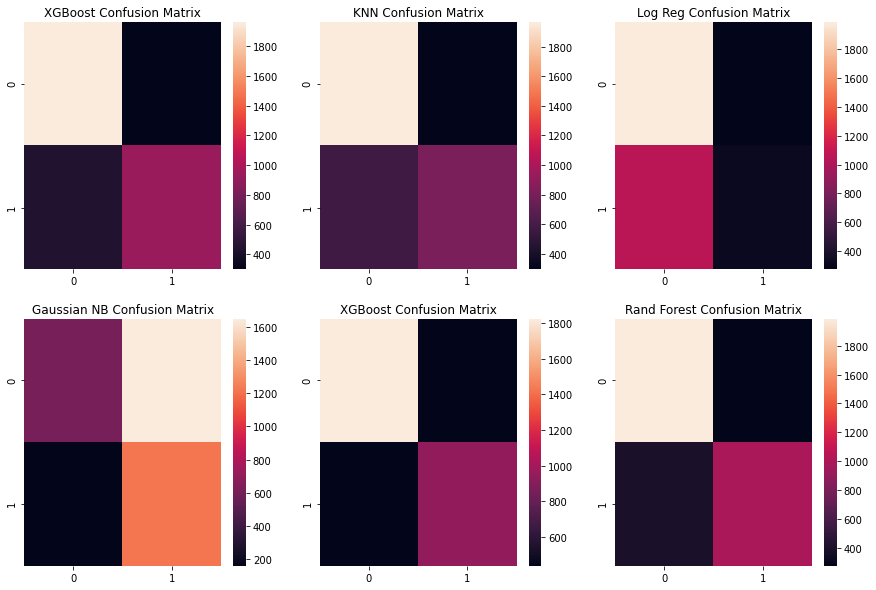

In [59]:
plt.rcParams['figure.figsize'] = 15, 10

figure, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3)
plot1 = sns.heatmap(confusion_matrix(y_test, xgb_y_pred), ax = ax1)
plot1.set_title('XGBoost Confusion Matrix')

plot2 = sns.heatmap(confusion_matrix(y_test, knn_y_pred), ax = ax2)
plot2.set_title('KNN Confusion Matrix')

plot3 = sns.heatmap(confusion_matrix(y_test, log_y_pred), ax = ax3)
plot3.set_title('Log Reg Confusion Matrix')

plot4 = sns.heatmap(confusion_matrix(y_test, gnb_y_pred), ax = ax4)
plot4.set_title('Gaussian NB Confusion Matrix')

plot5 = sns.heatmap(confusion_matrix(y_test, dt_y_pred), ax = ax5)
plot5.set_title('XGBoost Confusion Matrix')

plot6 = sns.heatmap(confusion_matrix(y_test, rf_y_pred), ax = ax6)
plot6.set_title('Rand Forest Confusion Matrix')

In [83]:
from sklearn.metrics import roc_auc_score, roc_curve

print("AUC: \n{}".format(roc_auc_score(y_test, voting_y_pred))) # 1.00 would be 100% correct model, 0.0 would be 100% wrong model
print("\n")
print("Receiver Operating Characteristic: \n{}".format(roc_curve(y_test, voting_y_pred)))

AUC: 
0.7926517291317059


Receiver Operating Characteristic: 
(array([0.        , 0.12516586, 1.        ]), array([0.        , 0.71046931, 1.        ]), array([2, 1, 0]))


False Positive Rate: [0.         0.12516586 1.        ]
True Prositive Rate: [0.         0.71046931 1.        ]


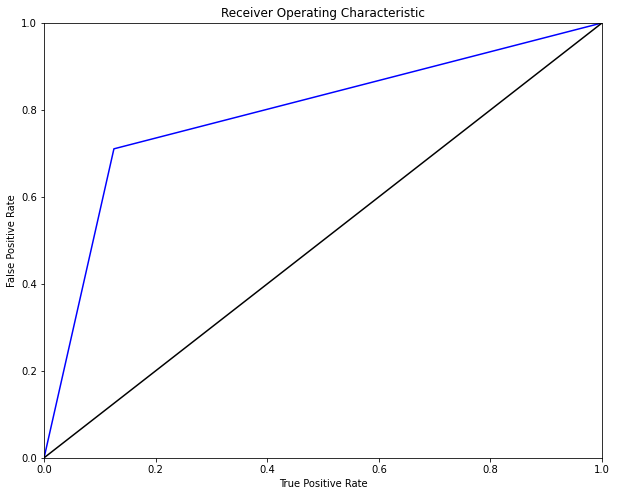

In [122]:
fpr, tpr, threshold = roc_curve(y_test, voting_y_pred)

print("False Positive Rate: {}".format(fpr))
print("True Prositive Rate: {}".format(tpr))

roc_auc = auc(fpr, tpr)


fig, ax = plt.subplots(ncols =1)


plt.rcParams['figure.figsize'] = 10, 8
plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr, 'b')
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.xlim([0,1])
plt.ylim([0,1])

x = np.linspace(*ax.get_xlim()) # 45 degree line to measure ROC...
plt.plot(x, x, 'black')
# The closer the ROC to the 45 degree line, the less accurate 

